In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

# settings

In [2]:
NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3
NL_L = 1.8

alfx = np.tan(np.pi*NL_nu)
bet0 = 0.9/alfx

In [3]:
order=3
NTURN = [1024*2,1024*4]
nCore_y=8
nCore_z=4


emit = 3.3e-6
eSpread = 2.0e-3
sigx = np.sqrt(bet0*emit)
sigy = np.sqrt(bet0*emit)

sigx,sigy

(0.0014689558564422289, 0.0014689558564422289)

### read impact lattice

In [4]:
beam,lattice = impact.readInputFile('../test.Chad.in')
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (../test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [5]:
lattice = impact.clearLattice(lattice)

In [6]:
for i,item in enumerate(lattice):
    if item.type == 'nonlinear_insert':
        break

# print(lattice[i-2])
# print(lattice[i-1])
# print(lattice[i  ])
# print(lattice[i+1])
# print(lattice[i+2])

lattice = lattice[i:] + lattice[:i]

# print(lattice[-2])
# print(lattice[-1])
# print(lattice[ 0])
# print(lattice[ 1])
# print(lattice[ 2])

In [7]:
lattice[0]


             length: 1.8 [m]
           n_sckick: 10 [1]
              n_map: 100 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
        pipe_radius: 10.0 [m]
       tune_advance: 0.3
               type: 'nonlinear_insert'

In [8]:
NL2 = impact.getElem('nonlinear_insert_sliced')
NL2.length = 0.9
NL2.start_position = 0.9

NL1 = impact.getElem('nonlinear_insert_sliced')
NL1.length = 0.9

lattice[0] = NL2
lattice.append(NL1)

### test particles

(8048, 251.5)

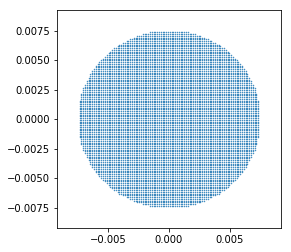

In [9]:
testP = 0.0
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 100
xmax = 5*sigx
ymax = 5*sigy
for x in np.linspace(-xmax,xmax,nx):
    for y in np.linspace(-ymax,ymax,nx):
        if (x/xmax)**2+(y/ymax)**2<=1.05 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k]) 
pTest = np.array(pTest)
npt0 = len(pTest)

impact.writeParticleData(pTest, ke, mass, freq)
beam.n_particles = npt0

plt.figure(figsize=(4,4))
plt.scatter(pTest[:,0],pTest[:,2],s=0.2)

npt0,npt0/(nCore_y*nCore_z)

In [10]:
for item in lattice:
    if item.type == 'RFkick':
        item.vmax = 0.0
    if item.type == 'nonlinear_insert':
        ElemNL = item
    if 'length' in item:
        item.n_sckick = int(np.ceil(item.length*50))
        item.n_map = 1

NL1.n_sckick = 1
NL1.n_map = 50
NL2.n_sckick = 1
NL2.n_map = 50

### forward lattice

In [11]:
Loop = impact.getElem('loop')

ElemTBT = impact.getElem('TBT')
ElemTBT.pID_begin = 1
ElemTBT.pID_end = npt0

OUTPUT = impact.getElem('write_raw_ptcl')
OUTPUT.format_id = 2

##### with QFF

In [12]:
quadIndex = []
quadStr = []
latticeQFF = copy(lattice)
for i,item in enumerate(latticeQFF):
    if item.type=='quad':
        quadIndex.append(i)
        quadStr.append(item.Kx)
        
for i,j in enumerate(quadIndex):
    heqf1 = impact.getElem('quad_hardedge')
    heqf1.n_map = 2
    heqf1.flagEntrance=True
    heqf1.Kx = quadStr[i]
    latticeQFF.insert(j+2*i,heqf1)
    heqf2 = copy(heqf1)
    heqf2.flagEntrance=False
    latticeQFF.insert(j+2*i+2,heqf2)
    

latticeQFF.insert(0,Loop)
latticeQFF.insert(1,ElemTBT)
latticeQFF.append(OUTPUT)

##### without QFF

In [13]:
lattice.insert(0,Loop)
lattice.insert(1,ElemTBT)
lattice.append(OUTPUT)

# Define runs

In [14]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [18]:
def run(latticeIn):
    ElemTBT.file_id = NTURN[0]
    OUTPUT.file_id = NTURN[0]
    OUTPUT.turn = NTURN[0]
    Loop.turns = NTURN[0]
    beam.distribution.distribution_type = 'ReadFile'
    impact.writeInputFile(beam,latticeIn)
#     impact.run(beam,order=order)
    for nturn in NTURN[:-1]:
        latticeIn[0].turns = nturn
        ElemTBT.file_id = nturn*2
        OUTPUT.turn = nturn
        OUTPUT.file_id = nturn*2
        Loop.turns = nturn
        beam.distribution.distribution_type = 'ReadFile_binary'
        beam.distribution.file_id = nturn
        impact.writeInputFile(beam,latticeIn) 
#         impact.run(beam,order=order)

        
    iTBT = {}
    TBT = {}
    Npt = {}
    # read TBT data
    for nturn in NTURN:
        iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
        TBT[nturn] = TBT[nturn][:,:4,:]
        Npt[nturn] = len(iTBT[nturn])


    # normalize TBT data
    XF = {}
    YF = {}
    for i in range(len(NTURN)):
        nturn = NTURN[i]
        npt = len(iTBT[nturn])
        XF[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        YF[nturn]=np.zeros((nturn,npt),dtype=np.complex)
        iturn = 0
        for j in range(i+1):
            jturn = NTURN[j]
            itmp = np.in1d(iTBT[jturn],iTBT[nturn])
            tmp = TBT[jturn][:,:,itmp]
            XF[nturn][iturn:jturn] = (tmp[:,0,:] - 1j*(bet0*tmp[:,1,:]))/np.sqrt(bet0)
            YF[nturn][iturn:jturn] = (tmp[:,2,:] - 1j*(bet0*tmp[:,3,:]))/np.sqrt(bet0)
            iturn = jturn

            
    # FMA
    tuneXbefore= {}
    tuneYbefore= {}
    Xdiff = {}
    Ydiff = {}
    Adiff = {}
    for nturn in NTURN[:-1]:
        nturn2 = 2*nturn
        npt = len(XF[nturn2][0,:])
        tuneXbefore[nturn] = np.zeros(npt)
        tuneYbefore[nturn] = np.zeros(npt)
        Xdiff[nturn] = np.zeros(npt)
        Ydiff[nturn] = np.zeros(npt)
        Adiff[nturn] = np.zeros(npt)
        for i in range(npt):
            signal = XF[nturn2][:nturn,i] -np.mean(XF[nturn2][:nturn,i])
            tuneXbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
            signal = XF[nturn2][nturn:,i] -np.mean(XF[nturn2][nturn:,i])
            tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
            Xdiff[nturn][i] = getClosestDiff(tuneXbefore[nturn][i],tune)
            signal = YF[nturn2][:nturn,i] -np.mean(YF[nturn2][:nturn,i])
            tuneYbefore[nturn][i],amp,dummy = impact.util.naff(1,signal,window_id=1)
            signal = YF[nturn2][nturn:,i] -np.mean(YF[nturn2][nturn:,i])
            tune,amp,dummy = impact.util.naff(3,signal,window_id=1)
            Ydiff[nturn][i] = getClosestDiff(tuneYbefore[nturn][i],tune)

        Adiff[nturn] = np.sqrt(Xdiff[nturn]**2 +Ydiff[nturn]**2)
        Adiff[nturn] = np.log10(Adiff[nturn]+1.0e-6)
            

    return {'X':copy(XF[NTURN[-1]]),'Y':copy(YF[NTURN[-1]]),'c':copy(Adiff[NTURN[-2]])}#,'rawX':XB,'rawY':YB}

In [19]:
data_QFF = run(latticeQFF)

In [ ]:
! rm fort.*
! rm TBT.*

In [21]:
data_noQFF = run(lattice)

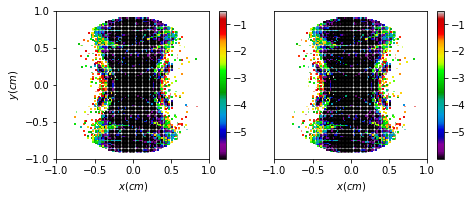

In [33]:
fig = plt.figure(figsize=[5.6*1.2,12/5*1.2])
plt.subplot(1,2,1)
data = data_noQFF
cmap = plt.scatter(100*data['X'][0,:].real,100*data['Y'][0,:].real,c=data['c'],s=0.7,marker='s',cmap='nipy_spectral')
xmin = 100*data['X'][0,:].real.min()
xmax = 100*data['X'][0,:].real.max()
ymin = 100*data['Y'][0,:].real.min()
ymax = 100*data['Y'][0,:].real.max()
# plt.xticks([-1,0,1])
# plt.yticks([-1,0,1])
# plt.xlim(xmin*1.1,xmax*1.1)
# plt.ylim(ymin*1.1,ymax*1.1)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('$x (cm)$')  
plt.ylabel('$y (cm)$')
plt.colorbar(cmap)

plt.subplot(1,2,2)
data = data_QFF
cmap = plt.scatter(100*data['X'][0,:].real,100*data['Y'][0,:].real,c=data['c'],s=0.7,marker='s',cmap='nipy_spectral')
# plt.xticks([-1,0,1])
# plt.yticks([-1,0,1])
# plt.xlim(xmin*1.1,xmax*1.1)
# plt.ylim(ymin*1.1,ymax*1.1)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('$x (cm)$')  
# plt.ylabel('$y$')
plt.yticks([])
plt.colorbar(cmap)

plt.tight_layout()
plt.savefig('FMA.DA.HEQFF.NLmid.png',dpi=270)
plt.savefig('FMA.DA.HEQFF.NLmid.eps',dpi=270)

In [26]:
Loop.turns=1
OUTPUT.turn=1
OUTPUT.file_id = 1000

bg = np.sqrt((1.0+ke/mass)**2-1.0)
beam.distribution.mode = 'twiss'
beam.distribution.distribution_type = 'Gauss'
beam.distribution.alfx = 0
beam.distribution.betx = bet0
beam.distribution.emitx = 3.3e-6*bg
beam.distribution.alfy = 0
beam.distribution.bety = bet0
beam.distribution.emity = 3.3e-6*bg
beam.distribution.betz = 0
beam.distribution.alfz = 0 
beam.distribution.emitz = 0 
beam.n_particles = 100000
beam.nCore_y = 4
beam.nCore_z = 4

impact.writeInputFile(beam,[Loop,OUTPUT])
impact.run(beam)

IMPACTz: linear dipoel finge model and linear drift propagator is assumed...


0

In [27]:
pData = impact.readParticleData(1000,ke,mass,freq,2)

In [28]:
levels = np.array([5.0e-2,8.00E-01, 1.60E+00, 2.40E+00, 3.20E+00, 4.00E+00, 4.80E+00])

In [29]:
np.all(levels==0)

False

In [ ]:
import pickle
# data = {'data_noQFF':data_noQFF,'data_QFF':data_QFF}
# pickle.dump(data,open('data','wb'))
# data=pickle.load(open('data','rb'))
# data_noQFF = data['data_noQFF']
# data_QFF = data['data_QFF']

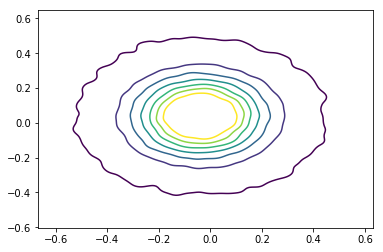

In [30]:
impact.plot.contour(100*pData[:,0],100*pData[:,2],edge=False,levels=levels)

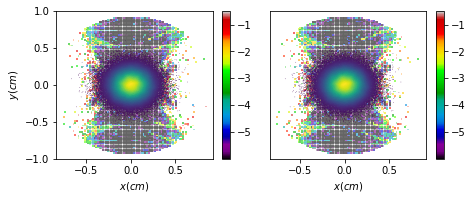

In [31]:
fig = plt.figure(figsize=[5.6*1.2,12/5*1.2])
ax1 = plt.subplot(1,2,1)
data = data_noQFF
cmap = plt.scatter(100*data['X'][0,:].real,100*data['Y'][0,:].real,c=data['c'],s=0.7,marker='s',cmap='nipy_spectral')
plt.scatter(0,0,c='white',s=100000,alpha=0.4)
impact.plot.density(100*pData[:,0],100*pData[:,2],mksize=0.4)
# impact.plot.contour(100*pData[:,0],100*pData[:,2],edge=False,levels=levels)
xmin = 100*data['X'][0,:].real.min()
xmax = 100*data['X'][0,:].real.max()
ymin = 100*data['Y'][0,:].real.min()
ymax = 100*data['Y'][0,:].real.max()
# plt.xticks([-1,0,1])
# plt.yticks([-1,0,1])
# plt.xlim(xmin*1.1,xmax*1.1)
# plt.ylim(ymin*1.1,ymax*1.1)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('$x (cm)$')  
plt.ylabel('$y (cm)$')
plt.colorbar(cmap)


ax2=plt.subplot(1,2,2)
data = data_QFF
cmap = plt.scatter(100*data['X'][0,:].real,100*data['Y'][0,:].real,c=data['c'],s=0.7,marker='s',cmap='nipy_spectral')
plt.scatter(0,0,c='white',s=100000,alpha=0.4)
impact.plot.density(100*pData[:,0],100*pData[:,2],mksize=0.4)
# contour = impact.plot.contour(100*pData[:,0],100*pData[:,2],edge=False,levels=levels)
# # plt.xticks([-1,0,1])
# # plt.yticks([-1,0,1])
# plt.xlim(xmin*1.1,xmax*1.1)
# plt.ylim(ymin*1.1,ymax*1.1)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('$x (cm)$')  
# plt.ylabel('$y$')
plt.yticks([])
plt.colorbar(cmap)


plt.tight_layout()
plt.savefig('FMA.DA.HEQFF.wCore.NLmid.png',dpi=270)
plt.savefig('FMA.DA.HEQFF.wCore.NLmid.eps',dpi=270)

In [34]:
Loop.turns=1
OUTPUT.turn=1
OUTPUT.file_id = 1000

bg = np.sqrt((1.0+ke/mass)**2-1.0)
beam.distribution.mode = 'twiss'
beam.distribution.distribution_type = 'IOTA_Gauss'
beam.distribution.NL_t  = 0.4
beam.distribution.NL_c  = 0.01
beam.distribution.betx  = bet0
beam.distribution.alfx  = 0
beam.distribution.emitx = emit
beam.distribution.CL    = 5.0
beam.distribution.betz  = 0.0
beam.distribution.alfz  = 0.0
beam.distribution.emitz = 0.0
beam.n_particles = 100000
beam.nCore_y = 4
beam.nCore_z = 4

impact.writeInputFile(beam,[Loop,OUTPUT])
impact.run(beam)

IMPACTz: linear dipoel finge model and linear drift propagator is assumed...


0

In [35]:
pData = impact.readParticleData(1000,ke,mass,freq,2)

In [36]:
levels = np.array([5.0e-2,8.00E-01, 1.60E+00, 2.40E+00, 3.20E+00, 4.00E+00, 4.80E+00])

In [37]:
np.all(levels==0)

False

In [38]:
import pickle
# data = {'data_noQFF':data_noQFF,'data_QFF':data_QFF}
# pickle.dump(data,open('data','wb'))
# data=pickle.load(open('data','rb'))
# data_noQFF = data['data_noQFF']
# data_QFF = data['data_QFF']

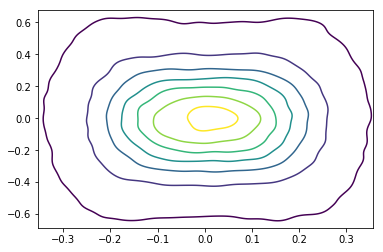

In [39]:
# impact.plot.contour(100*pData[:,0],100*pData[:,2],edge=False,levels=levels)

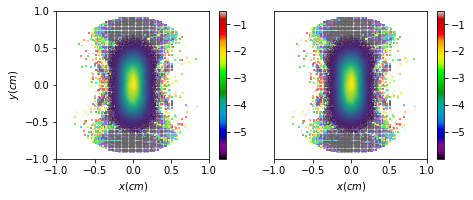

In [41]:
fig = plt.figure(figsize=[5.6*1.2,12/5*1.2])
ax1 = plt.subplot(1,2,1)
data = data_noQFF
cmap = plt.scatter(100*data['X'][0,:].real,100*data['Y'][0,:].real,c=data['c'],s=0.7,marker='s',cmap='nipy_spectral')
plt.scatter(0,0,c='white',s=100000,alpha=0.4)
impact.plot.density(100*pData[:,0],100*pData[:,2],mksize=0.4)
# impact.plot.contour(100*pData[:,0],100*pData[:,2],edge=False,levels=levels)
xmin = 100*data['X'][0,:].real.min()
xmax = 100*data['X'][0,:].real.max()
ymin = 100*data['Y'][0,:].real.min()
ymax = 100*data['Y'][0,:].real.max()
# plt.xticks([-1,0,1])
# plt.yticks([-1,0,1])
# plt.xlim(xmin*1.1,xmax*1.1)
# plt.ylim(ymin*1.1,ymax*1.1)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('$x (cm)$')  
plt.ylabel('$y (cm)$')
plt.colorbar(cmap)


ax2=plt.subplot(1,2,2)
data = data_QFF
cmap = plt.scatter(100*data['X'][0,:].real,100*data['Y'][0,:].real,c=data['c'],s=0.7,marker='s',cmap='nipy_spectral')
plt.scatter(0,0,c='white',s=100000,alpha=0.4)
impact.plot.density(100*pData[:,0],100*pData[:,2],mksize=0.4)
# contour = impact.plot.contour(100*pData[:,0],100*pData[:,2],edge=False,levels=levels)
# # plt.xticks([-1,0,1])
# # plt.yticks([-1,0,1])
# plt.xlim(xmin*1.1,xmax*1.1)
# plt.ylim(ymin*1.1,ymax*1.1)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('$x (cm)$')  
# plt.ylabel('$y$')
plt.yticks([])
plt.colorbar(cmap)


plt.tight_layout()
plt.savefig('FMA.DA.HEQFF.wNonlinearCore.NLmid.png',dpi=270)
plt.savefig('FMA.DA.HEQFF.wNonlinearCore.NLmid.eps',dpi=270)